# COGS 108 - EDA Checkpoint

# Names

- Leica Shen
- Yuxuan Wu
- Eddie Ho
- Xuewen Yang

<a id='research_question'></a>
# Research Question

How has the COVID-19 pandemic impact global warming? Specifically, how do changes in greenhouse gas emissions from 2020 to 2022 resulting from pandemic-related lockdowns impact the rate of global temperature increase and sea level rise?

# Setup

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm


In [32]:
temp_change = pd.read_csv('data/global_land_and_ocean_temp_anomalies.csv', skiprows=4)
temp_change.head()

,Year,Value
0,190001,-0.30
1,190002,-0.17
2,190003,-0.03
3,190004,-0.05
4,190005,-0.06


In [33]:
temp_change.shape

(1480, 2)

In [34]:
sea_level = pd.read_csv('data/Change_in_Mean_Sea_Levels.csv').drop(columns='ObjectId')
sea_level.head()

,Country,ISO2,ISO3,Indicator,Unit,Source,CTS_Code,CTS_Name,CTS_Full_Descriptor,Measure,Date,Value
0,World,NaN,WLD,Change in mean sea level: Sea level: TOPEX.Pos...,Millimeters,National Oceanic and Atmospheric Administratio...,ECCL,Change in Mean Sea Level,"Environment, Climate Change, Climate Indicator...",Andaman Sea,D12/17/1992,-10.34
1,World,NaN,WLD,Change in mean sea level: Sea level: TOPEX.Pos...,Millimeters,National Oceanic and Atmospheric Administratio...,ECCL,Change in Mean Sea Level,"Environment, Climate Change, Climate Indicator...",Arabian Sea,D12/17/1992,-18.46
2,World,NaN,WLD,Change in mean sea level: Sea level: TOPEX.Pos...,Millimeters,National Oceanic and Atmospheric Administratio...,ECCL,Change in Mean Sea Level,"Environment, Climate Change, Climate Indicator...",Atlantic Ocean,D12/17/1992,-15.41
3,World,NaN,WLD,Change in mean sea level: Sea level: TOPEX.Pos...,Millimeters,National Oceanic and Atmospheric Administratio...,ECCL,Change in Mean Sea Level,"Environment, Climate Change, Climate Indicator...",Baltic Sea,D12/17/1992,196.85
4,World,NaN,WLD,Change in mean sea level: Sea level: TOPEX.Pos...,Millimeters,National Oceanic and Atmospheric Administratio...,ECCL,Change in Mean Sea Level,"Environment, Climate Change, Climate Indicator...",Bay Bengal,D12/17/1992,3.27


In [35]:
sea_level.shape

(35604, 12)

In [36]:
CO2_Concentrations = pd.read_csv('data/Atmospheric_CO2_Concentrations.csv').drop(columns='ObjectId')
CO2_Concentrations.head()

,Country,ISO2,ISO3,Indicator,Unit,Source,CTS_Code,CTS_Name,CTS_Full_Descriptor,Date,Value
0,World,NaN,WLD,Monthly Atmospheric Carbon Dioxide Concentrations,Parts Per Million,"Dr. Pieter Tans, National Oceanic and Atmosphe...",ECCA,Atmospheric Carbon Dioxide Concentrations,"Environment, Climate Change, Climate Indicator...",1958M03,315.70
1,World,NaN,WLD,Monthly Atmospheric Carbon Dioxide Concentrations,Parts Per Million,"Dr. Pieter Tans, National Oceanic and Atmosphe...",ECCA,Atmospheric Carbon Dioxide Concentrations,"Environment, Climate Change, Climate Indicator...",1958M04,317.45
2,World,NaN,WLD,Monthly Atmospheric Carbon Dioxide Concentrations,Parts Per Million,"Dr. Pieter Tans, National Oceanic and Atmosphe...",ECCA,Atmospheric Carbon Dioxide Concentrations,"Environment, Climate Change, Climate Indicator...",1958M05,317.51
3,World,NaN,WLD,Monthly Atmospheric Carbon Dioxide Concentrations,Parts Per Million,"Dr. Pieter Tans, National Oceanic and Atmosphe...",ECCA,Atmospheric Carbon Dioxide Concentrations,"Environment, Climate Change, Climate Indicator...",1958M06,317.24
4,World,NaN,WLD,Monthly Atmospheric Carbon Dioxide Concentrations,Parts Per Million,"Dr. Pieter Tans, National Oceanic and Atmosphe...",ECCA,Atmospheric Carbon Dioxide Concentrations,"Environment, Climate Change, Climate Indicator...",1958M07,315.86


In [37]:
CO2_Concentrations.shape

(1548, 11)

# Data Cleaning

Describe your data cleaning steps here.

### sea_level table

1. Extract `Year` and `Month` of each observation from the `Date` column and convert them into `int` data type. \
    The `Year` and `Month` columns from the above step will be combined with only the `Measure` and `Value` columns from the `sea_level` table. \
    The resulting merged data will be stored in the `sea_level_cleaned` table.
    

In [38]:
sea_level_cleaned = pd.merge(sea_level[['Measure', 'Value']], sea_level['Date'].str.split('D', expand=True)[1].str.split('/', expand=True)[[0,2]].rename(columns={0:'Month', 2:'Year'}), left_index=True, right_index=True)
sea_level_cleaned['Year'] = sea_level_cleaned['Year'].astype(int)
sea_level_cleaned['Month'] = sea_level_cleaned['Month'].astype(int)
sea_level_cleaned.head()

,Measure,Value,Month,Year
0,Andaman Sea,-10.34,12,1992
1,Arabian Sea,-18.46,12,1992
2,Atlantic Ocean,-15.41,12,1992
3,Baltic Sea,196.85,12,1992
4,Bay Bengal,3.27,12,1992


2. Group by `Year` and `Month`, get the mean of `Value` of the `sea_level_cleaned` table. \
    The resulting table will be stored in the `mean_sea_level_by_month` table. \
    

In [39]:
mean_sea_level_by_month = sea_level_cleaned.groupby(['Year', 'Month'])[['Value']].mean().reset_index().sort_values(['Year', 'Month']) 
mean_sea_level_by_month.head()

,Year,Month,Value
0,1992,12,4.265600
1,1993,1,-14.385067
2,1993,2,-31.307733
3,1993,3,-39.215733
4,1993,4,-49.520400


3. Group by `Measure` and `Year`, get the mean value of `Value` of the `sea_level_cleaned` table. \
    The resulting table will be stored in the `mean_sea_level_by_sea` table.

In [40]:
mean_sea_level_by_sea = sea_level_cleaned.groupby(['Measure', 'Year'])[['Value']].mean().reset_index().sort_values(['Measure', 'Year']) 
mean_sea_level_by_sea.head()

,Measure,Year,Value
0,Adriatic Sea,1992,-21.360000
1,Adriatic Sea,1993,-47.668824
2,Adriatic Sea,1994,-23.842353
3,Adriatic Sea,1995,-19.478750
4,Adriatic Sea,1996,2.120303


### temp_change table

1. Create `temp_change_cleaned` data frame to store the cleaned data. 
2. Extract `Year` column from the original `temp_change` data frame, convert those dates to strings. 
3. Use string slicing to retrieve `Year` and `Month` from the dates in the uncleaned data frame, converts them to int, and then assign them to the corresponding `Year` and `Month` column of the cleaned `temp_change_cleaned` data frame. 
4. Sort the cleaned data in `temp_change_cleaned` by the `Year` and `Month` of the data. 

In [41]:
temp_change_cleaned = temp_change.copy()
time = temp_change['Year'].astype(str)
temp_change_cleaned['Year'] = time.str[:4].astype(int)
temp_change_cleaned['Month'] = time.str[4:].astype(int)
temp_change_cleaned = temp_change_cleaned.groupby(['Year', 'Month']).mean().reset_index().sort_values(['Year', 'Month']) 
temp_change_cleaned.head()

,Year,Month,Value
0,1900,1,-0.30
1,1900,2,-0.17
2,1900,3,-0.03
3,1900,4,-0.05
4,1900,5,-0.06


### CO2_Concentrations table

1. Create `CO2_cleaned` dataframe to store the cleaned data.
2. Extract `Date` column from the original `CO2_cleaned` dataframe, use string slicing to retrieve `Year` and `Month`, and then assign them to the corresponding `Year` and `Month` column of the cleaned `CO2_cleaned` dataframe.
3. Drop rows where `Unit` = `Percent` as we won't be performing on those records.
4. Sort the cleaned data in `CO2_cleaned` by `Year` and `Month` of the data.

In [42]:
# Extract the year and month from the date column
CO2_cleaned = (
    CO2_Concentrations
    .assign(Year=CO2_Concentrations['Date'].str.split('M').map(lambda x: x[0]).astype(int),
            Month=CO2_Concentrations['Date'].str.split('M').map(lambda x: x[1]).astype(int))
    .drop(columns=['Date'])
)

# Remove the percent values
CO2_cleaned = CO2_cleaned[CO2_cleaned['Unit'] != 'Percent']

# Sort the values by year and month
CO2_cleaned = (
    CO2_cleaned
    .sort_values(['Year', 'Month'])
    .get(['Year', 'Month', 'Value'])
)

CO2_cleaned

,Year,Month,Value
0,1958,3,315.70
1,1958,4,317.45
2,1958,5,317.51
3,1958,6,317.24
4,1958,7,315.86
...,...,...,...
1538,2022,10,415.78
1540,2022,11,417.51
1542,2022,12,418.95
1544,2023,1,419.47


### Merging data sets

Our plan for combining these datasets: 
1. Merge the first dataset Temp Anomalies with the second dataset Change in Mean Sea Levels on the Year / Month columns.

2. Merge this combined dataset with the third dataset Atmospheric CO2 Concentrations again on the Year / Month columns.

In [43]:
# Merge the two dataframes
mean_sea_level_by_month = mean_sea_level_by_month.rename(columns={'Value': 'Sea_Level'})
temp_change_cleaned = temp_change_cleaned.rename(columns={'Value': 'Temp_Anomaly'})
temp_sealevel_df = pd.merge(mean_sea_level_by_month, temp_change_cleaned, how='inner', on=['Year', 'Month'])
temp_sealevel_df.head()

,Year,Month,Sea_Level,Temp_Anomaly
0,1992,12,4.265600,0.22
1,1993,1,-14.385067,0.34
2,1993,2,-31.307733,0.39
3,1993,3,-39.215733,0.38
4,1993,4,-49.520400,0.36


The resulting merged data frame will have columns of `Year`, `Month`, `sea-level_value`, `temp_value`, `CO2_value`：

In [44]:
CO2_cleaned = CO2_cleaned.rename(columns={'Value': 'CO2_Concentration'})
merged_df = pd.merge(temp_sealevel_df, CO2_cleaned, how='inner', on=['Year', 'Month'])
merged_df['Year_Month'] = pd.to_datetime(merged_df['Year'].astype(str)+ '-' + merged_df['Month'].astype(str))
merged_df.head()

,Year,Month,Sea_Level,Temp_Anomaly,CO2_Concentration,Year_Month
0,1992,12,4.265600,0.22,355.68,1992-12-01
1,1993,1,-14.385067,0.34,357.10,1993-01-01
2,1993,2,-31.307733,0.39,357.42,1993-02-01
3,1993,3,-39.215733,0.38,358.59,1993-03-01
4,1993,4,-49.520400,0.36,359.39,1993-04-01


# Data Analysis & Results (EDA)

### CO2_Concentration

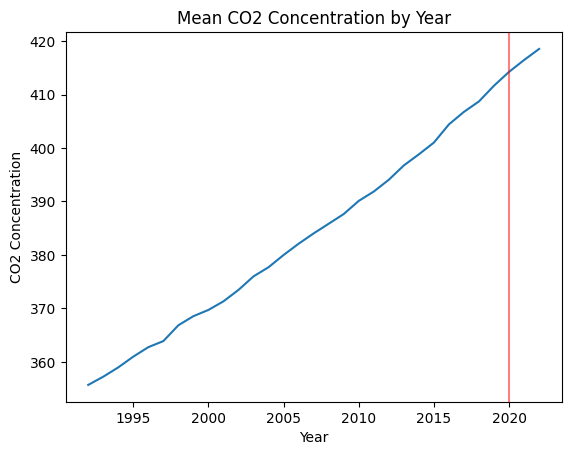

In [45]:
merged_df.groupby('Year')['CO2_Concentration'].mean().plot()
plt.xlabel('Year')
plt.ylabel('CO2 Concentration')
plt.title('Mean CO2 Concentration by Year')
plt.axvline(x=2020, color='red', alpha=0.5)
plt.show()

TODO

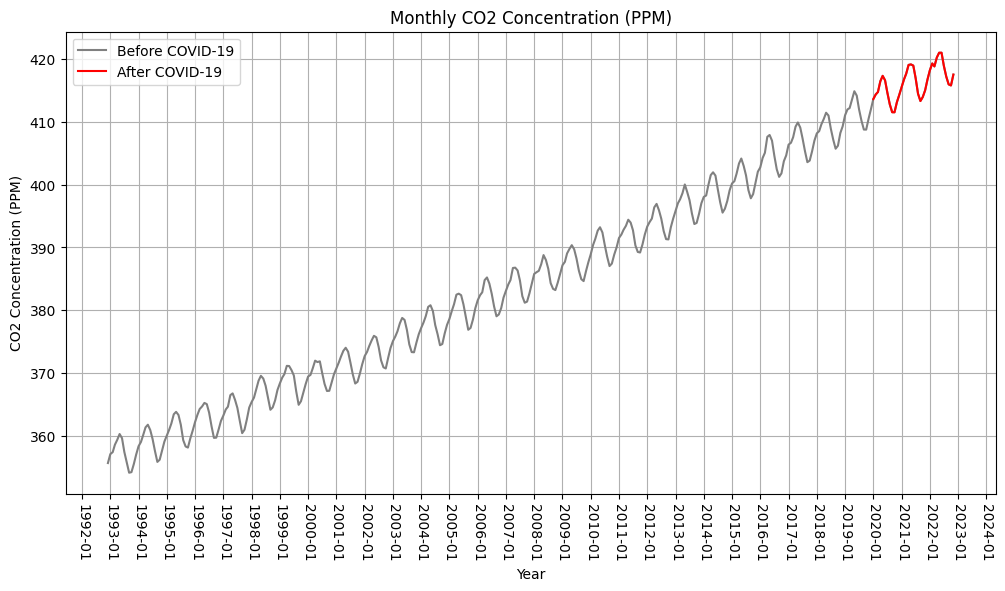

In [46]:
# Create a boolean mask for dates after 2019-12-01
mask = merged_df['Year_Month'] > pd.to_datetime('2019-12-01')

plt.figure(figsize=(12, 6))
plt.plot(merged_df['Year_Month'], merged_df['CO2_Concentration'], label='Before COVID-19', color='gray')

# Use boolean mask to highlight data after Covid-19 outbreak
plt.plot(merged_df['Year_Month'][mask], merged_df['CO2_Concentration'][mask], label='After COVID-19', color='red')

plt.title('Monthly CO2 Concentration (PPM)')
plt.xlabel('Year')
plt.ylabel('CO2 Concentration (PPM)')
plt.legend()

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.grid(True)
plt.xticks(rotation=-90)

plt.show()

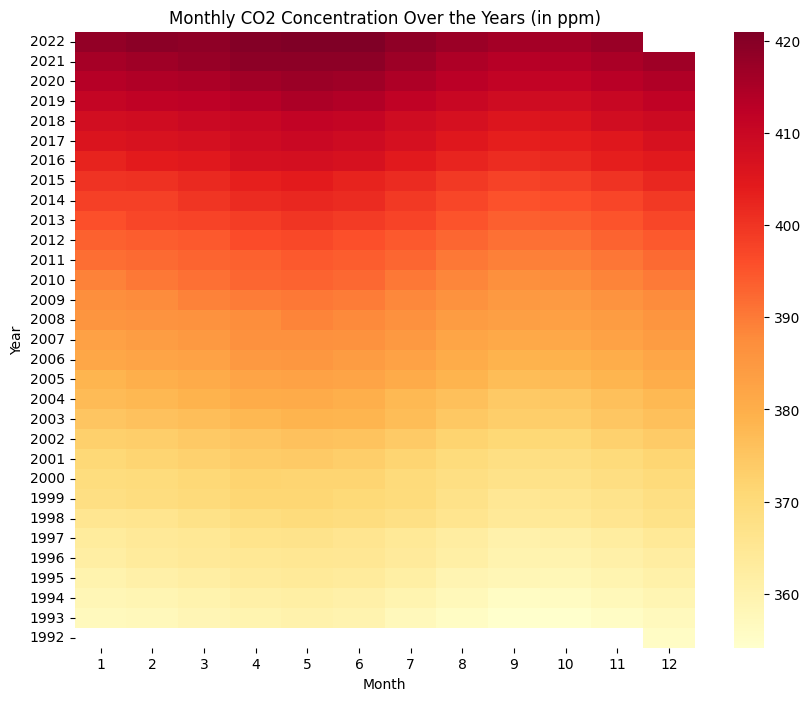

In [59]:
# Create a new DataFrame with years as index, months as columns, and CO2 concentration as values
heatmap_data = merged_df.pivot(index='Year', columns='Month', values='CO2_Concentration')
heatmap_data = heatmap_data.sort_index(axis=0, ascending=False)

# Draw the heatmap for monthly CO2 concentration
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='YlOrRd')

plt.title('Monthly CO2 Concentration Over the Years (in PPM)')
plt.xlabel('Month')
plt.ylabel('Year')

plt.show()

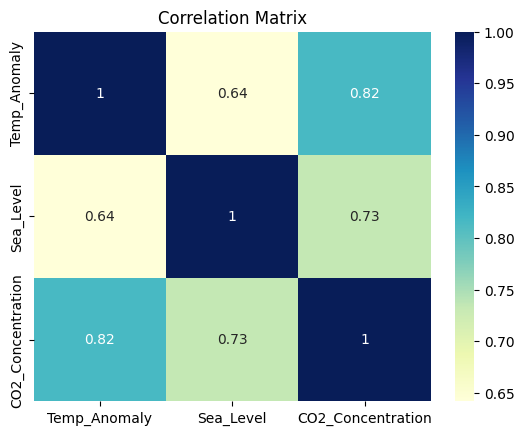

In [48]:
# Correlation analysis
correlation_matrix = merged_df[['Temp_Anomaly', 'Sea_Level', 'CO2_Concentration']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.show()

### Temp_Anomaly

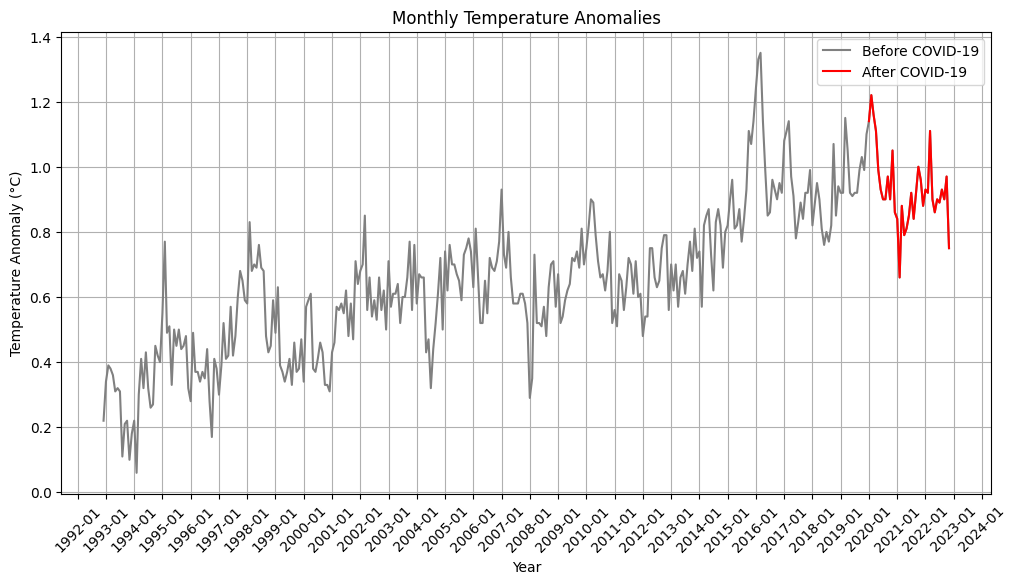

In [49]:
# Temperature Anomly per Year
# Create a boolean mask for dates after 2019-12-01
mask = merged_df['Year_Month'] > pd.to_datetime('2019-12-01')

plt.figure(figsize=(12, 6))

# Plot all data with a lighter color
plt.plot(merged_df['Year_Month'], merged_df['Temp_Anomaly'], label='Before COVID-19', color='gray')

# Use boolean mask to plot data after 2019-12-01 with a different color
plt.plot(merged_df['Year_Month'][mask], merged_df['Temp_Anomaly'][mask], label='After COVID-19', color='red')

plt.title('Monthly Temperature Anomalies')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.grid(True)
plt.show()

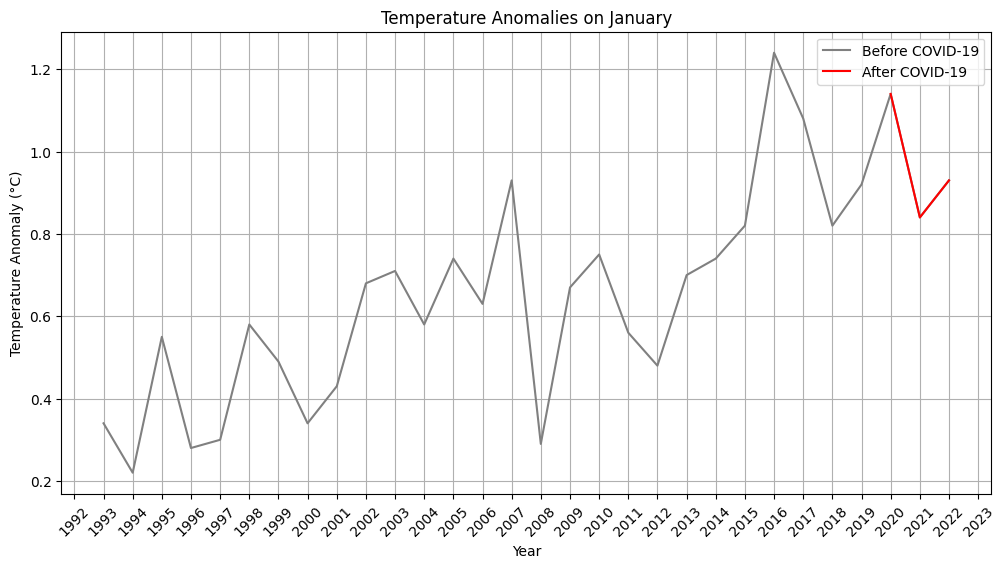

In [50]:
plt.figure(figsize=(12, 6))

df = merged_df[merged_df['Month'] == 1]

mask = (df['Year_Month'] > pd.to_datetime('2019-12-01')) & (df['Year_Month'] < pd.to_datetime('2022-12-01'))

# Plot all data with a lighter color
plt.plot(df['Year_Month'], df['Temp_Anomaly'], label='Before COVID-19', color='gray')

# Use boolean mask to plot data after 2019-12-01 with a different color
plt.plot(df['Year_Month'][mask], df['Temp_Anomaly'][mask], label='After COVID-19', color='red')

plt.title('Temperature Anomalies on January')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.grid(True)
plt.show()

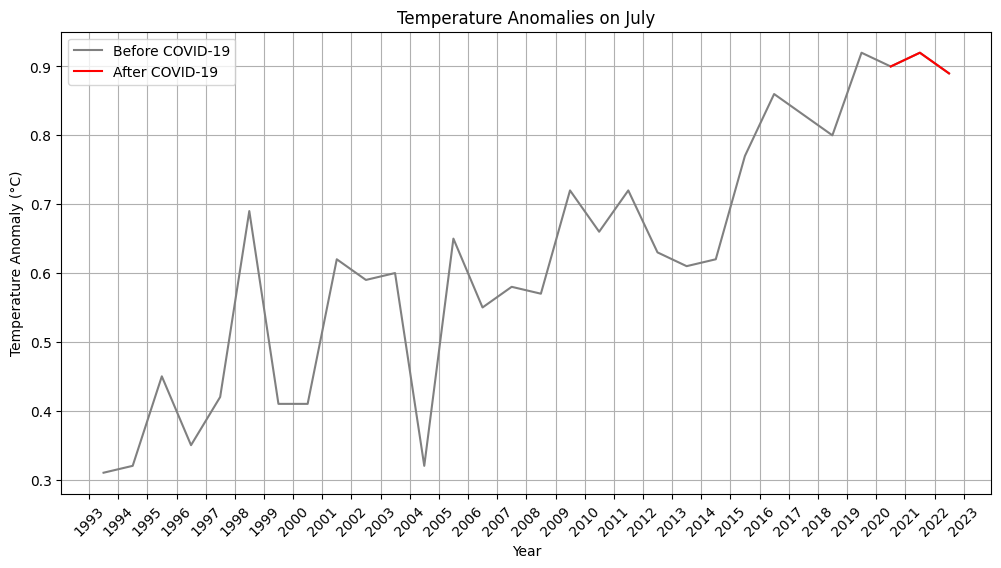

In [51]:
plt.figure(figsize=(12, 6))

df = merged_df[merged_df['Month'] == 7]

mask = (df['Year_Month'] > pd.to_datetime('2019-12-01')) & (df['Year_Month'] < pd.to_datetime('2022-12-01'))

# Plot all data with a lighter color
plt.plot(df['Year_Month'], df['Temp_Anomaly'], label='Before COVID-19', color='gray')

# Use boolean mask to plot data after 2019-12-01 with a different color
plt.plot(df['Year_Month'][mask], df['Temp_Anomaly'][mask], label='After COVID-19', color='red')

plt.title('Temperature Anomalies on July')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Rotate x-axis labels
plt.xticks(rotation=45)

plt.grid(True)
plt.show()

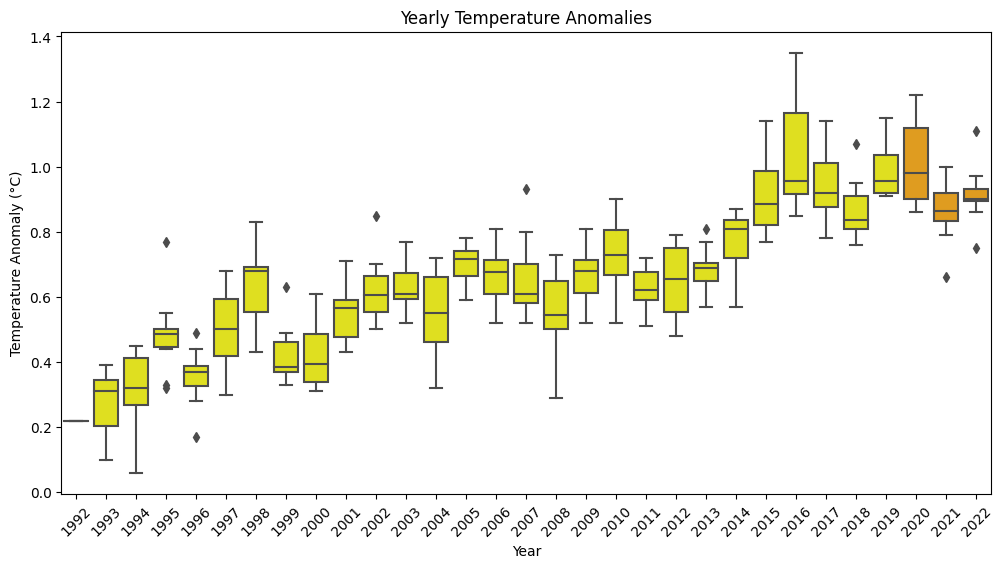

In [52]:
# Create a palette that maps each year to a color based on whether it's before or after 2020
palette = {year: 'orange' if year >= 2020 else 'yellow' for year in merged_df['Year'].unique()}

plt.figure(figsize=(12, 6))

# Create a boxplot with the custom color palette
sns.boxplot(x="Year", y="Temp_Anomaly", data=merged_df, palette=palette)

plt.title('Yearly Temperature Anomalies')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')

plt.xticks(rotation=45)

plt.show()

### Sea_Level

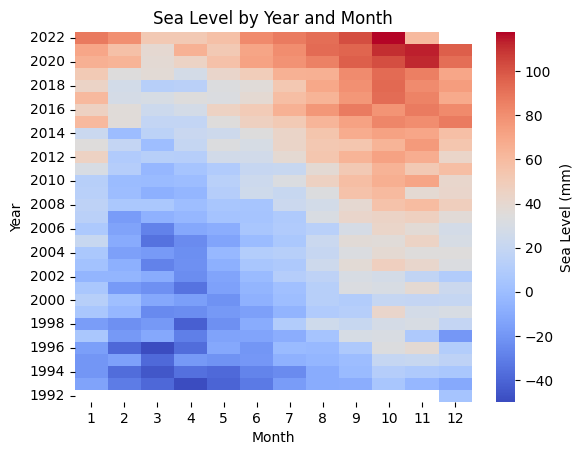

In [53]:
heatmap_data = merged_df.pivot_table(values='Sea_Level', index='Year', columns='Month').sort_index(ascending=False)
sns.heatmap(data=heatmap_data, cmap='coolwarm', cbar_kws={'label': 'Sea Level (mm)'})
plt.title('Sea Level by Year and Month')
plt.show()

<Axes: xlabel='Year_Month', ylabel='Value'>

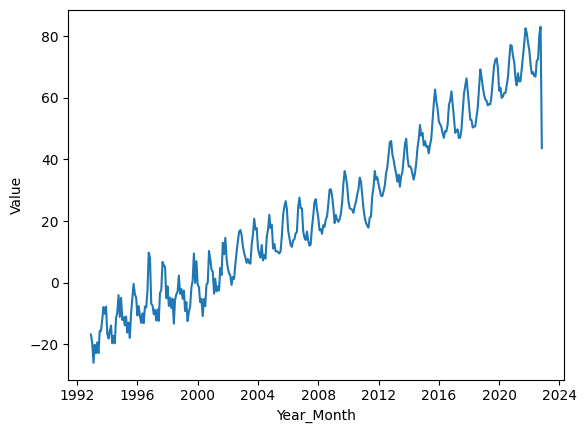

In [54]:
sea_level_cleaned['Year_Month'] = pd.to_datetime(sea_level_cleaned['Year'].astype(str) + '-' + sea_level_cleaned['Month'].astype(str))
sea_level_world = sea_level_cleaned[sea_level_cleaned['Measure'] == 'World']
sea_level_cleaned.head()
sns.lineplot(x='Year_Month', y='Value', data=sea_level_world, errorbar=None)

In [55]:
# Extracting the relevant columns
sea_level_data = sea_level_world[['Year', 'Value']]

# Perform linear regression
# Adding a constant term for the intercept
X = sm.add_constant(sea_level_data['Year'])
y = sea_level_data['Value']
model = sm.OLS(y, X)
results = model.fit()

# Extract slope and p-value
slope = results.params['Year']
p_value = results.pvalues['Year']

# Print regression results summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                 1.502e+04
Date:                Sat, 27 May 2023   Prob (F-statistic):               0.00
Time:                        15:40:44   Log-Likelihood:                -4854.0
No. Observations:                1426   AIC:                             9712.
Df Residuals:                    1424   BIC:                             9723.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6072.3960     49.756   -122.043      0.0

In [56]:
# Hypothesis testing
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis. Sea level is rising.")
else:
    print("Fail to reject the null hypothesis. No significant evidence of sea level rise.")

Reject the null hypothesis. Sea level is rising.


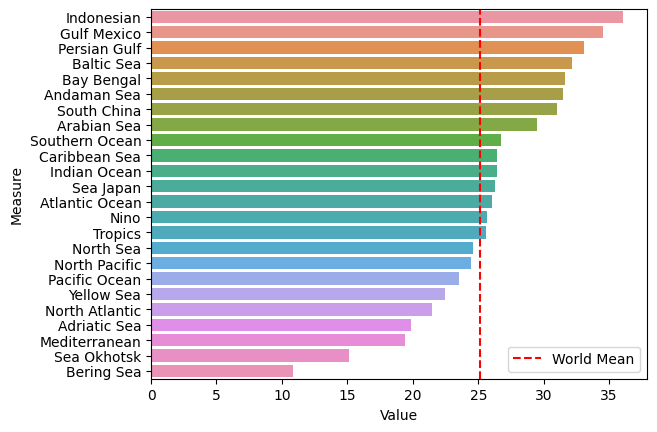

In [57]:
sea_level_by_year = (sea_level_cleaned
                     [sea_level_cleaned['Measure'] != 'World']
                     .groupby('Measure')
                     [['Value']]
                     .mean()
                     .reset_index())
mean_sea_level_world = (sea_level_cleaned
                        .loc[sea_level_cleaned['Measure'] == 'World', 'Value']
                        .mean(numeric_only=None))

sns.barplot(x='Value', y='Measure',
            data=sea_level_by_year.sort_values('Value', ascending=False))
plt.axvline(x=mean_sea_level_world, color='red', linestyle='--', label='World Mean')
plt.legend();